## Cellsighter
A notebook walking through a step-by-step process of how to run cellsighter with training and evaluation.

```text
# Directory Structure
|   .gitignore
|   CellSighterLogo.jpg
|   data_exploration.ipynb
|   eval.py
|   model.py
|   README.md
|   requirements.txt
|   train.py
|   __init__.py
|
+---analyze_results
|       confusion_matrix.py
|       unified_ensemble.py
|       __init__.py
|
+---data
|       cell_crop.py
|       data.py
|       shift_augmentation.py
|       transform.py
|       utils.py
|       __init__.py
|
+---example_experiment
|   +---MelanomaLymphNode
|       |   channels.txt
|       |   config.json
|       |   labels_strings.txt
|       |
|       +---cells
|       |       1.npz # etc...
|       |
|       +---cells2labels
|       |       1.npz # etc...
|       |
|       \---data
|           \---images
|                   1.npz # etc...
|       |
\---metrics
        metrics.py
```

### channels.txt
The 25 channels in this example in order.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import ast

with open('./example_experiment/MelanomaLymphNode/channels.txt', 'r') as file:
    channels = file.read()
print(channels)

CD4
CD8
CD20
CD14
CD68
CD206
CD11c
CD21
CD3
CD56
Granzyme B
CD163
Foxp3
S100A9-Calprotectin
CD45RA
CD45RO
CCR7
MelanA
SOX10
CD45
CD31
SMA
MECA-79
COL1A1
DC-SIGN



### label_strings.txt
The 15 possible cell types for multi-class prediction.

In [3]:
with open('./example_experiment/MelanomaLymphNode/labels_strings.txt', 'r') as file:
    label_strings_raw = file.read()
    label_strings = ast.literal_eval(label_strings_raw)

print(label_strings_raw)

{0: 'B cell',
 1: 'CD4 T cell',
 2: 'CD4 Treg',
 3: 'CD8 T cell',
 4: 'DCs',
 5: 'Germinal Center B cell',
 6: 'Hevs',
 7: 'Immune',
 8: 'MAC',
 9: 'Memory CD4 T Cells',
 10: 'NK cell',
 11: 'Neutrophil',
 12: 'Stroma',
 13: 'Tumor',
 14: 'Vessels'}


### Data: ./cells
A folder of .npz files that contain label images of segmentation. Below we can just display the label image for the 14th sample. The pseudo-random coloring is just to distinguish cell boundaries.

<class 'numpy.ndarray'>


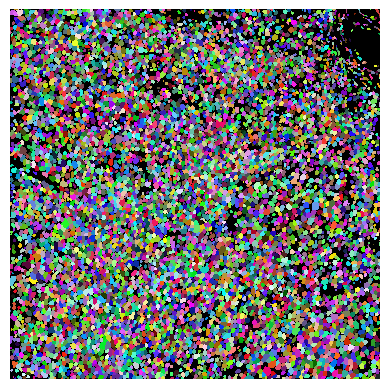

(2048, 2048)
(8397,)


In [4]:
data = np.load('./example_experiment/MelanomaLymphNode/CellTypes/cells/14.npz')

cells = data['data']
cells = cells.astype(float)
print(type(cells))

unique_labels = np.unique(cells)
colors = np.random.rand(len(unique_labels) - 1, 3)
background_color = np.array([0, 0, 0])
colors = np.vstack([background_color, colors])
cmap = mcolors.ListedColormap(colors)

plt.imshow(cells, cmap=cmap, interpolation='nearest')
plt.axis('off')
plt.show()

print(cells.shape)
print(unique_labels.shape)

### Data: ./cells2labels
A folder of .npz files that define the label_string index for each ROI. Set to -1 if no label. For this first sample, there are 8397 ROIs.

In [8]:
data = np.load('./example_experiment/MelanomaLymphNode/CellTypes/cells2labels/14.npz')

labels = data['data']
print(labels)
print(labels.shape)

#nolabels = np.count_nonzero(labels == -1) 
#print(nolabels)

[-1.  1.  1. ...  9.  0.  1.]
(8397,)


### Data: ./data/images
A folder of .npz files that contain the normalized, multiplexed image data. Below we can just display one of the channels (E.g., CD14) for the 14th sample.

(2048, 2048, 25)


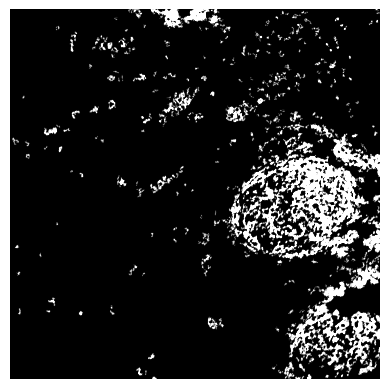

In [16]:
data = np.load('./example_experiment/MelanomaLymphNode/CellTypes/data/images/14.npz')

images = data['data']
print(images.shape)

channel = 3 # E.g., this is CD14
image_slice = images[:,:,channel]

plt.imshow(images[:,:,channel], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

### Cell type annotation
Ground truth labels for cell type annotations from cells2label. Note the large class imbalance. According to the manuscript, if "sample_batch" is set to true in the config file, it will upsample the minority classes through additional augmentation (E.g., rotation/ translation).

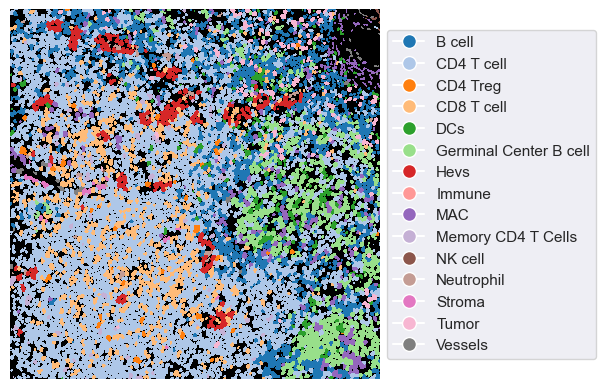

In [17]:
default_cmap = plt.get_cmap('tab20')
num_classes = len(label_strings)
colors = [default_cmap(i) for i in range(num_classes)]
colors = np.vstack(([0, 0, 0, 1], colors))
cmap = mcolors.ListedColormap(colors)

label_image = np.zeros_like(cells)

for roi_id in np.unique(cells):
    if roi_id == 0:
        continue
    roi_id_int = int(roi_id)
    if roi_id_int < len(labels):
        class_label = int(labels[roi_id_int])
        if class_label != -1:  # Ignore ROIs with label -1
            label_image[cells == roi_id] = class_label + 1  # +1 to map background as 0

plt.figure()
im = plt.imshow(label_image, cmap=cmap, interpolation='nearest')
plt.axis('off')

handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=colors[i + 1], markersize=10)
    for i in range(num_classes)
]
legend_labels = [label_strings[i] for i in range(num_classes)]
plt.legend(handles, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Model configuration

Define configuration parameters for model training and evaluation. Note, the weight_to_eval parameter will write an absolute file path to the config.json, potentially revealing directory structures. This should be fixed later.

In [7]:
import json
import os

# Define the config path (relative path)
config_path = './configuration/config.json'

if os.path.exists(config_path):
    try:
        with open(config_path, 'r') as file:
            config = json.load(file)
    except json.JSONDecodeError:
        print("Warning: config.json is empty or invalid. Creating a new configuration.")
        config = {}
else:
    config = {}

# Define the base path for configuration folder
base_path = os.path.abspath('./configuration')

config.update({
    "crop_input_size": 60,
    "crop_size": 128,
    "root_dir": "./example_experiment/MelanomaLymphNode",
    "train_set": ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"],
    "val_set": ["13", "14", "15", "16"],
    "num_classes": 15,
    "epoch_max": 10,
    "lr": 0.001,
    "batch_size": 4,
    "to_pad": False,
    "blacklist": [],
    "channels_path": "./example_experiment/MelanomaLymphNode/channels.txt",
    
    # Ensure that the path is relative to the base_path (config.json will set an ABSOLUTE PATH)
    "weight_to_eval": os.path.join(base_path, "weights_9_count.pth"), #set to "" training only

    "sample_batch": True,
    "hierarchy_match": {
        "0": "B cell",
        "1": "T cell",
        "2": "T cell",
        "3": "T cell",
        "4": "Myeloid",
        "5": "B cell",
        "6": "Vascular",
        "7": "Immune",
        "8": "Myeloid",
        "9": "T cell",
        "10": "NK cell",
        "11": "Myeloid",
        "12": "Stroma",
        "13": "Tumor",
        "14": "Vascular"
    },
    "size_data": 1000,
    "aug": True,
    "num_workers": 0
})

with open(config_path, 'w') as file:
    json.dump(config, file, indent=4)

print("Configuration file updated successfully.")


Configuration file updated successfully.


### Training and evaluation 
- Each epoch, the model .pth is stored in the configuration directory.
- Every 10 epochs, A CSV file for validation results is generated: val_results_{epoch_number}.csv if uncommented in the train.py.
- TensorBoard: You can monitor the loss and other metrics live on the TensorBoard interface (http://localhost:6006/).
- **To generate the model weights, I ran through the first 12 images as the training set for 9 epochs.**

In [8]:
## run the commands below in the terminal:

# python train.py --base_path '.\\configuration'
# tensorboard --logdir '.\\configuration'

# python eval.py --base_path '.\\configuration'

## if running evaluation, ensure "weight_to_eval" is defined in the .json

### Confusion matrix
Plotting a confusion matrix allows us to visualize which classes were correctly vs. incorrectly annotated. Numbers 0-14 correspond to cell types from label_strings.txt, which is re-printed to the console below for convenience.

{0: 'B cell',
 1: 'CD4 T cell',
 2: 'CD4 Treg',
 3: 'CD8 T cell',
 4: 'DCs',
 5: 'Germinal Center B cell',
 6: 'Hevs',
 7: 'Immune',
 8: 'MAC',
 9: 'Memory CD4 T Cells',
 10: 'NK cell',
 11: 'Neutrophil',
 12: 'Stroma',
 13: 'Tumor',
 14: 'Vessels'}


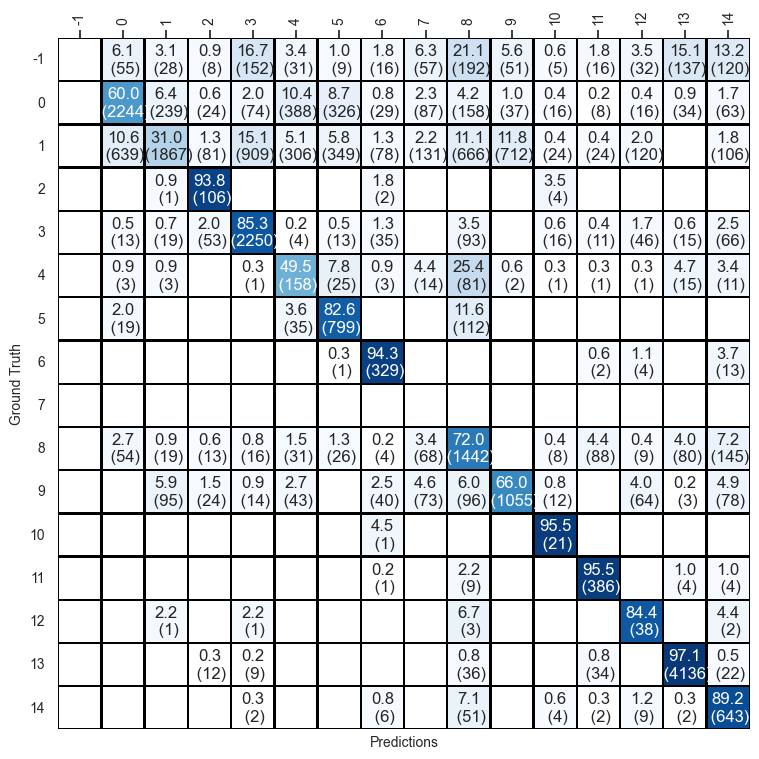

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

def metric(gt, pred, classes_for_cm, colorbar=False):
    sns.set(font_scale=1)
    cm_normed_recall = confusion_matrix(gt, pred, labels=classes_for_cm, normalize="true") * 100
    cm = confusion_matrix(gt, pred, labels=classes_for_cm)

    plt.figure(figsize=(15,15))
    ax1 = plt.subplot2grid((50,50), (0,0), colspan=30, rowspan=30)
    cmap = LinearSegmentedColormap.from_list('', ['white', *plt.cm.Blues(np.arange(255))])
    annot_labels = cm_normed_recall.round(1).astype(str)
    annot_labels = pd.DataFrame(annot_labels) + "\n (" + pd.DataFrame(cm).astype(str) + ")"
    annot_mask = cm_normed_recall.round(1) <= 0.1
    annot_labels[annot_mask] = ""
    
    sns.heatmap(
        cm_normed_recall,
        ax=ax1,
        annot=annot_labels,
        fmt='',
        cbar=colorbar,
        cmap=cmap,
        linewidths=1,
        vmin=0,
        vmax=100,
        linecolor='black',
        square=True,
        cbar_kws={
            "shrink": 0.5,
            "orientation": "horizontal",
            "pad": 0.1
        }
    )
    ax1.xaxis.tick_top()
    ax1.set_xticklabels(classes_for_cm, rotation=90, fontsize=10)
    ax1.set_yticklabels(classes_for_cm, rotation=0, fontsize=10)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.set_xlabel("Predictions", fontsize=10)
    ax1.set_ylabel("Ground Truth", fontsize=10)

results = pd.read_csv("./configuration/val_results.csv")
classes_for_cm = np.unique(np.concatenate([results["label"], results["pred"]]))
metric(results["label"], results["pred"], classes_for_cm)

print(label_strings_raw)

### Visualizing predictions
Using the val_results.csv, we can visualize where the predictions were inconsistent with the ground-truth label. Because this was only run for 9 epochs with no real optimization, it is unlikely to look that good. Here, the ROIs are set to red if the predictions did not match the ground-truth label, and they are colored blue if they were matching. The evaluation set was defined as 13-16 in the config.json.

Processing Image ID: 13


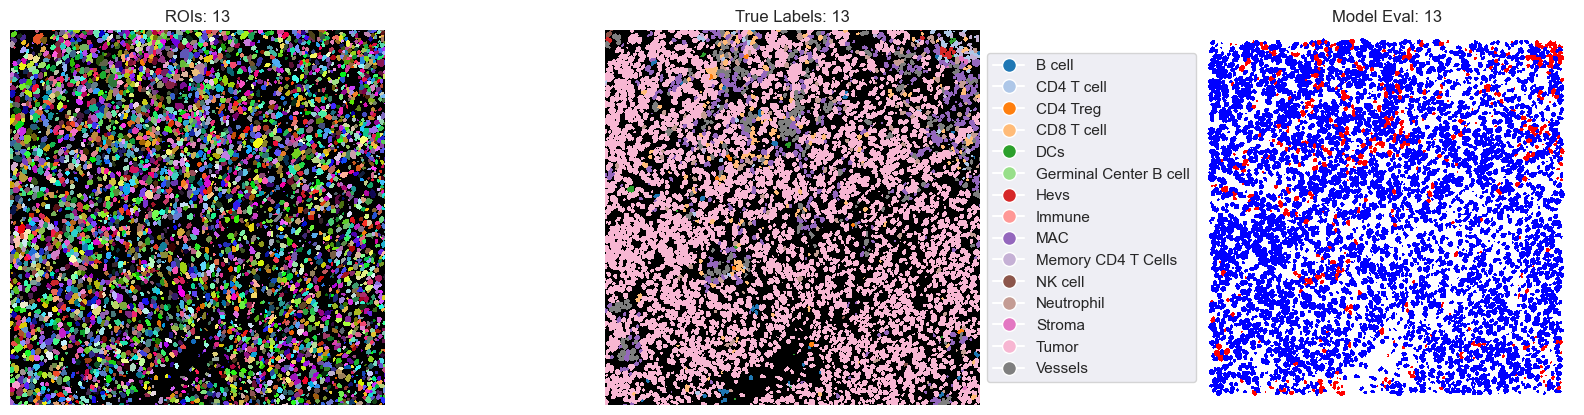

Processing Image ID: 14


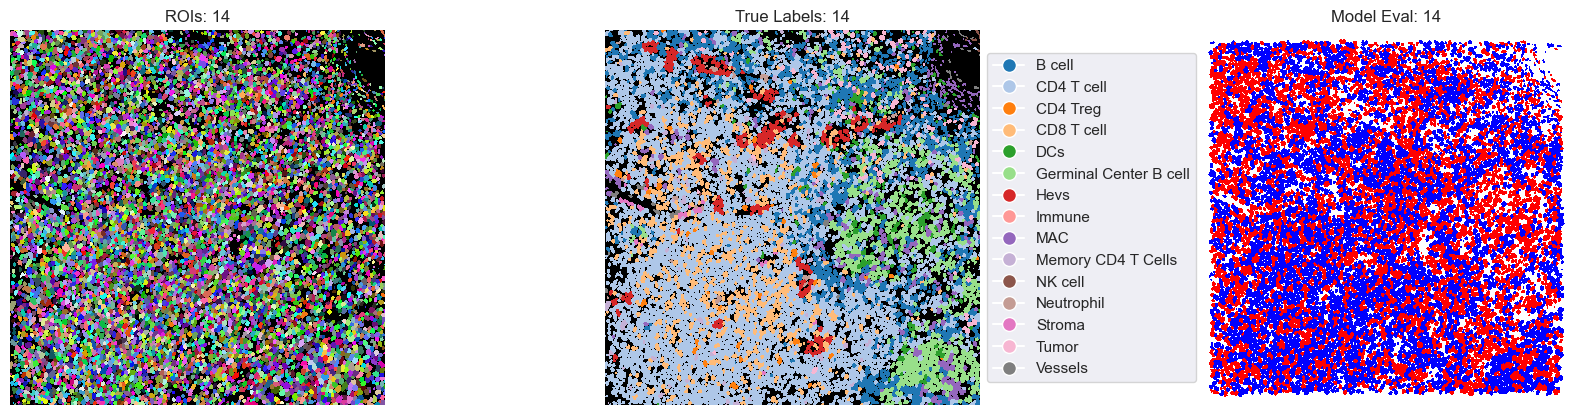

Processing Image ID: 15


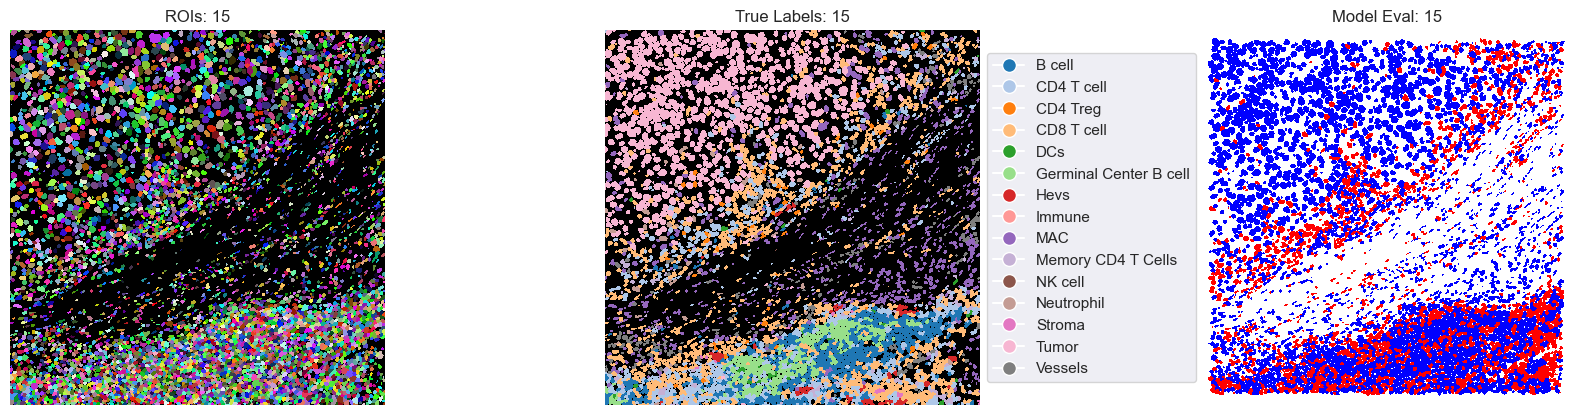

Processing Image ID: 16


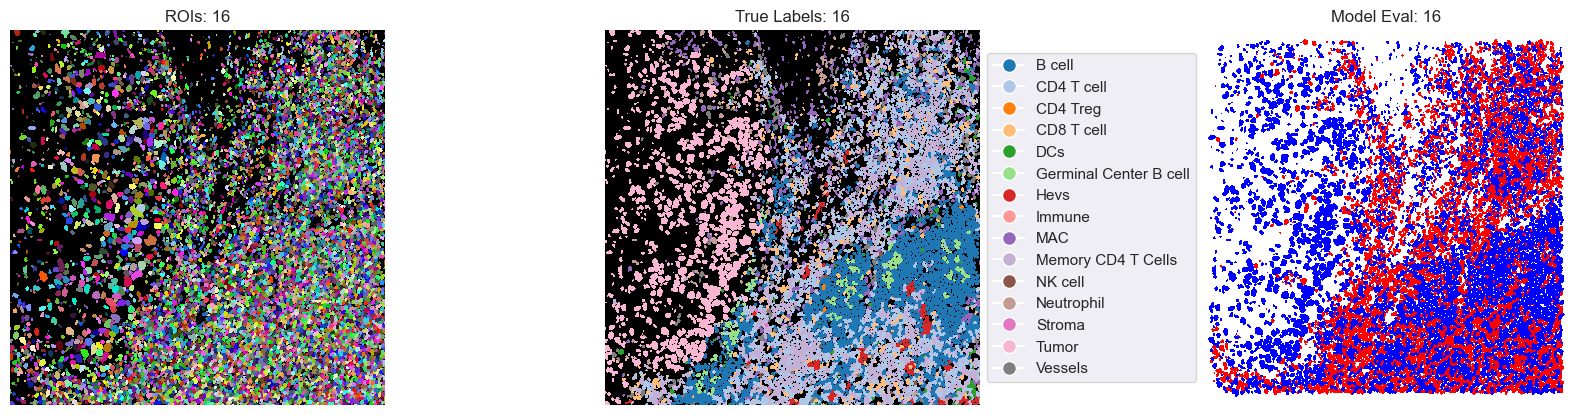

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ast

with open('./example_experiment/MelanomaLymphNode/labels_strings.txt', 'r') as file:
    label_strings = ast.literal_eval(file.read())

csv_path = './configuration/val_results.csv'
eval_results = pd.read_csv(csv_path)

cells_dir = './example_experiment/MelanomaLymphNode/CellTypes/cells'
labels_dir = './example_experiment/MelanomaLymphNode/CellTypes/cells2labels'

image_ids = [13, 14, 15, 16] # it would be better if this were pulled automatically from the .csv

for image_id in image_ids:
    print(f"Processing Image ID: {image_id}")

    data = np.load(os.path.join(cells_dir, f'{image_id}.npz'))
    cells = data['data'].astype(float)

    # Random-colored ROIs
    unique_labels = np.unique(cells)
    colors = np.random.rand(len(unique_labels) - 1, 3)
    colors = np.vstack(([0, 0, 0], colors))
    cmap_random = mcolors.ListedColormap(colors)

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cells, cmap=cmap_random, interpolation='nearest')
    plt.axis('off')
    plt.title(f"ROIs: {image_id}")

    # True labels using tab20
    label_data = np.load(os.path.join(labels_dir, f'{image_id}.npz'))
    labels = label_data['data']

    default_cmap = plt.get_cmap('tab20')
    num_classes = len(label_strings)
    colors = [default_cmap(i) for i in range(num_classes)]
    colors = np.vstack(([0, 0, 0, 1], colors))
    cmap_labels = mcolors.ListedColormap(colors)

    label_image = np.zeros_like(cells)
    for roi_id in np.unique(cells):
        if roi_id == 0:
            continue
        roi_id_int = int(roi_id)
        if roi_id_int < len(labels):
            class_label = int(labels[roi_id_int])
            if class_label != -1:
                label_image[cells == roi_id] = class_label + 1

    plt.subplot(1, 3, 2)
    plt.imshow(label_image, cmap=cmap_labels, interpolation='nearest')
    plt.axis('off')
    plt.title(f"True Labels: {image_id}")

    handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=colors[i + 1], markersize=10)
        for i in range(num_classes)
    ]
    legend_labels = [label_strings[i] for i in range(num_classes)]
    plt.legend(handles, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # Model evaluation results
    eval_image = np.ones((*cells.shape, 3))

    image_results = eval_results[eval_results['image_id'] == image_id]
    for _, row in image_results.iterrows():
        cell_id = row['cell_id']
        pred = row['pred']
        label = row['label']
        color = [0, 0, 1] if pred == label else [1, 0, 0]
        eval_image[cells == cell_id] = color

    plt.subplot(1, 3, 3)
    plt.imshow(eval_image, interpolation='nearest')
    plt.axis('off')
    plt.title(f"Model Eval: {image_id}")

    plt.subplots_adjust(wspace=0.05, hspace=0)
    plt.tight_layout()
    plt.show()


Clearly, the model performs well on certain cell types, but misclassifies many of the cells belonging to minority classes. There is likely some imbalance in the training set or alternatively some fine tuning needed for model hyperparameters. At any rate, this is a good starting point for training a real model.